### Featurization and training classifiers on the still image dataset

Parameters
* detection confidence  -  check from realtime detection
* tracking confidence  -  check from realtime detection
* presence confidence  -  check from realtime detection
* CLASSIFIER: random forest - n_estimators / MLPClassifier - lr, alpha, optimizer, hidden size, batch size, lr_init, momentum, activation

Using SMOTE for class balancing
* Note that the test set has at least two classes with only one example that depending on the split might bias the accuracy (that's why we consider weighted accuracy)

In [1]:
import numpy as np
import mediapipe as mp
import pickle
from prepare_data import parse_image_folder
from extract_features import *
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import cv2

seed = 333

In [3]:
# still image dataset path
directory = "/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/image_data"

# get standardized images and labels
X, labels, df = parse_image_folder(directory)

print('Number of images:', len(X))

print("shape of an image:", X[0].shape)

Number of images: 2754
shape of an image: (256, 256, 3)


In [ ]:
# extract landmarks: MEDIAPIPE 
min_pose_detection_confidence = 0.7  # biggest effect
min_pose_presence_confidence = 0.5
min_tracking_confidence = 0.5

mp_model_path = "../pretrained_models/pose_landmarker_heavy.task"
detector = mediapipe_detector(mp_model_path,
                              min_pose_detection_confidence=min_pose_detection_confidence,
                              min_pose_presence_confidence=min_pose_presence_confidence,
                              min_tracking_confidence=min_tracking_confidence,)

x_data = np.zeros((len(X), MP_N_LANDMARKS * 4))  # For pose landmarks
y_data = np.zeros(labels.shape)  # For labels

c = 0

# run inference on every image
for i in range(len(X)):
    landmarks = mediapipe_detect(detector, X[i])
    # only include images with detected landmarks
    if landmarks is not None:
        # with detected poses
        if len(landmarks.pose_landmarks) != 0:
            x_data[i], y_data[i] = mediapipe_format_landmark(landmarks, labels[i])
            
            # draw one example detection
            if c < 1000:
                annotated_image = draw_landmarks_on_image(X[i], landmarks)
                cv2.imwrite(f'/Users/alejandraduran/Documents/Pton_courses/COS429/visualize_landmarks_mediapipe_2/{i}.jpg', cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))     
                c += 1      
                
# drop images without detected poses
non_zero_mask = np.any(x_data != 0, axis=(1,))
x_data = x_data[non_zero_mask]
y_data = y_data[y_data != 0]

In [14]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, shuffle=True, random_state=seed
)
print('Number of training samples:', len(X_train))

# recover the indices
x_data_index = np.arange(len(x_data), dtype=int)
y_data_index = np.arange(len(y_data), dtype=int)

index_train, index_test, index_train, index_test = train_test_split(
    x_data_index, y_data_index, test_size=0.2, shuffle=True, random_state=seed
)

# save the landmark training datasets
with open(f'new_landmark_datasets/landmark_train_heavy_256_pad_{min_pose_detection_confidence}_{min_pose_presence_confidence}_{min_tracking_confidence}.pkl', 'wb') as f:
    pickle.dump([X_train, y_train], f)
    
with open(f'new_landmark_datasets/landmark_test_heavy_256_pad_{min_pose_detection_confidence}_{min_pose_presence_confidence}_{min_tracking_confidence}.pkl', 'wb') as f:
    pickle.dump([X_test, y_test], f)

Number of training samples: 1848


In [16]:
# print statistics on class composition 
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)
y_train_counts = y_train_series.value_counts()
y_test_counts = y_test_series.value_counts()
# print the median, mean, stdv, max and min of the class distribution
print('Train class distribution')
print(y_train_counts.describe())
print('Test class distribution')
print(y_test_counts.describe())

# class balancing - somehow did not work when the confidence > 0.8?? 
# would not accept neighbors > 1
smote_k_neighbors = 3 
smote = SMOTE(random_state=seed, k_neighbors=smote_k_neighbors, sampling_strategy='not majority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# save class distributions before and after rebalancing
y_before_rebalance = pd.Series(y_train).value_counts()
y_after_rebalance = pd.Series(y_resampled).value_counts()
with open(f'rebalancing_analysis/SMOTE_{smote_k_neighbors}.pkl', 'wb') as f:
    pickle.dump((y_before_rebalance, y_after_rebalance), f)
    
print('Number of training samples after SMOTE:', len(X_resampled))

# save the rebalanced data
with open(f'new_landmark_datasets/landmark_train_resampled_256_heavy_pad_{min_pose_detection_confidence}_{min_pose_presence_confidence}_{min_tracking_confidence}.pkl', 'wb') as f:
    pickle.dump([X_resampled, y_resampled], f)
    
# print statistics on class composition 
y_train_series = pd.Series(y_resampled)
y_train_counts = y_train_series.value_counts()
# print the median, mean, stdv, max and min of the class distribution
print('Train class distribution after resampling')
print(y_train_counts.describe())


Train class distribution
count    47.000000
mean     39.319149
std      17.319386
min       6.000000
25%      28.000000
50%      45.000000
75%      52.000000
max      69.000000
Name: count, dtype: float64
Test class distribution
count    47.000000
mean      9.851064
std       5.594946
min       1.000000
25%       6.000000
50%      10.000000
75%      13.000000
max      26.000000
Name: count, dtype: float64
Number of training samples after SMOTE: 3243
Train class distribution after resampling
count    47.0
mean     69.0
std       0.0
min      69.0
25%      69.0
50%      69.0
75%      69.0
max      69.0
Name: count, dtype: float64


In [43]:
# train RF classifier (neural net has different script)

from sklearn.metrics import classification_report

# train a random forest classifier
rf = RandomForestClassifier(random_state=seed, n_estimators=300, max_depth=100)

rf.fit(X_resampled, y_resampled)

# save the model
with open(f'/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/rf_pad.pkl', 'wb') as f:
    pickle.dump(rf, f)
    
# #load the classifier
# with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/rf_pad.pkl', 'rb') as f:
#     model = pickle.load(f)

# # load the corresponding test data
# with open(f'landmark_datasets/landmark_test_DROP_256_0.7_0.5_0.5.pkl', 'rb') as f:
#     X_test, y_test = pickle.load(f)

    
y_pred = rf.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract per-class accuracy
per_class_accuracy = {label: metrics['recall'] for label, metrics in report.items() if label != 'accuracy'}

print("Per Class Accuracy:")
for label, accuracy in per_class_accuracy.items():
    print(f"Class {label}: {accuracy:.2f}")

f1 = f1_score(y_test, y_pred, average='macro')
precision=precision_score(y_test, y_pred, average='macro')
recall=recall_score(y_test, y_pred, average='macro')

print(f"F1 {f1}", f"Precision {precision}, Recall {recall}")


Per Class Accuracy:
Class 1.0: 0.91
Class 2.0: 0.73
Class 3.0: 0.00
Class 4.0: 0.57
Class 5.0: 0.75
Class 6.0: 1.00
Class 7.0: 1.00
Class 8.0: 0.88
Class 9.0: 0.00
Class 10.0: 0.89
Class 11.0: 0.89
Class 12.0: 0.88
Class 13.0: 0.77
Class 14.0: 1.00
Class 15.0: 1.00
Class 16.0: 0.60
Class 17.0: 0.92
Class 18.0: 0.86
Class 19.0: 1.00
Class 20.0: 0.89
Class 21.0: 0.75
Class 22.0: 0.67
Class 23.0: 1.00
Class 24.0: 0.50
Class 25.0: 0.71
Class 26.0: 0.67
Class 27.0: 0.73
Class 28.0: 1.00
Class 29.0: 0.89
Class 30.0: 0.83
Class 31.0: 0.94
Class 32.0: 1.00
Class 33.0: 0.00
Class 34.0: 1.00
Class 35.0: 0.60
Class 36.0: 0.80
Class 37.0: 0.90
Class 38.0: 0.70
Class 39.0: 0.75
Class 40.0: 1.00
Class 41.0: 0.91
Class 42.0: 0.89
Class 43.0: 0.81
Class 44.0: 0.62
Class 45.0: 0.79
Class 46.0: 1.00
Class 47.0: 1.00
Class macro avg: 0.79
Class weighted avg: 0.83
F1 0.7659210172045874 Precision 0.77617051421231, Recall 0.7867045623904525


/Users/alejandraduran/opt/anaconda3/envs/cos429/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alejandraduran/opt/anaconda3/envs/cos429/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alejandraduran/opt/anaconda3/envs/cos429/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

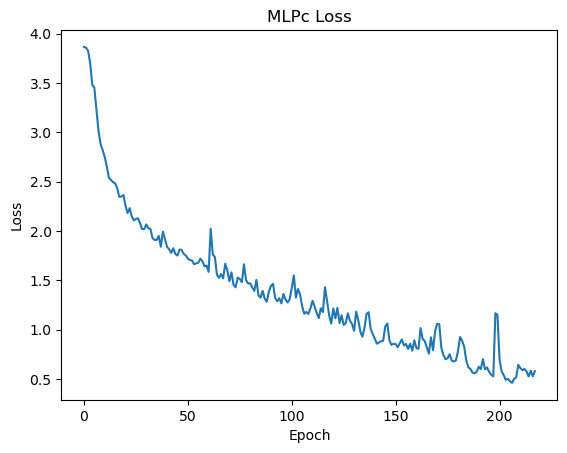

In [35]:
# visualize neural net

# with open('/Users/alejandraduran/Documents/Pton_courses/COS429/COS429_final_project/trained_classifiers/neural_network_best_drop2.pkl', 'rb') as f:
#     nn = pickle.load(f)
    
# plot the loss
import matplotlib.pyplot as plt
plt.plot(nn.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLPc Loss')
plt.show()


In [ ]:
# Visualize correct and incorrect labeled images

# Assuming index_test is your array of indices
index_test = np.array(index_test, dtype=int)
# Ensure it is 1-dimensional
index_test = index_test.flatten()
# Assuming X_images is a list and index_test is your array of indices
X_images = np.array(X_images)
# get the test images from the split
X_images_test = X_images[index_test]

# visualize 10 correct labeled images
correct = np.where(y_test == y_pred)[0]
for i in correct[:10]:
    # pass in the landmark coordinates as (landmark, xyz(v) coords)
    annotated_image = draw_landmarks_on_image(X_images_test[i], landmark_coords=X_test[i].reshape(-1, 4))
    cv2.imwrite(f'correct_predictions/{i}.jpg', cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))  
    
# visualize 10 incorrect labeled images
incorrect = np.where(y_test != y_pred)[0]
for i in incorrect[:10]:
    annotated_image = draw_landmarks_on_image(X_images_test[i], landmark_coords=X_test[i].reshape(-1, 4))
    cv2.imwrite(f'incorrect_predictions/{i}.jpg', cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))   